Time Series Analisys for Soybean

In [1]:
# !pip install yfinance

In [2]:
!pip install -U statsmodels

You should consider upgrading via the '/Users/vanessalieberg/.pyenv/versions/3.8.12/envs/project_commodity_prices/bin/python -m pip install --upgrade pip' command.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

from sklearn.linear_model import LinearRegression

from statsmodels.tsa.seasonal import seasonal_decompose

In [4]:
# Variables of soybeans and soy sub-products
# soyMeal = yf.Ticker('ZM=F')
# soyOil = yf.Ticker('ZL=F')
soybean = yf.Ticker('ZS=F')

# soyMeal = soyMeal.history(period="max")
# soyOil = soyOil.history(period="max")
soybean = soybean.history(period="max")

# Lists I use for manipulating the dataframe for each commodity
commodities = [soybean]
commodityName = ['soybean']



In [5]:
# Drop all columns except date and close price, rename close price to name of the commodity
col2drop = ['Open', 'High', 'Low', 'Volume', 'Dividends', 'Stock Splits']
count = 0

for i in commodities:
    i.drop(columns = col2drop, axis = 0, inplace = True)
    i.columns = [commodityName[count]]
    count += 1

In [6]:
# Join all data frames into one
df = pd.concat(commodities, join='outer', axis=1)

# Some prices are missing for things like holidays, use forward fill to make the missing values the same as the previous
df.ffill()
df.dropna()

,soybean
Date,
2000-09-15,493.75
2000-09-18,484.00
2000-09-19,484.25
2000-09-20,483.25
2000-09-21,486.50
...,...
2022-03-14,1687.25
2022-03-15,1658.75
2022-03-16,1649.25


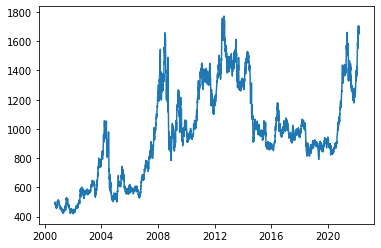

In [7]:
plt.plot(df);

In [8]:
y = df.values


In [9]:
# let's keep the last 40% values out for test purposes
train_size = 0.6
index = round(train_size*df.shape[0])
df_train = df.iloc[:index]
df_test = df.iloc[index:]

In [10]:
y_pred = df_test.shift(1)
y_pred

,soybean
Date,
2013-08-13,NaN
2013-08-14,1359.75
2013-08-15,1368.00
2013-08-16,1288.25
2013-08-19,1283.25
...,...
2022-03-14,1690.75
2022-03-15,1687.25
2022-03-16,1658.75


In [11]:
from sklearn.metrics import r2_score

y_pred = df_test.shift(1).dropna()
y_true = df_test[1:]
print(f"R2:{r2_score(y_true, y_pred)}")

R2:0.9946932865142957


# Linear model with 12 auto-regressive features

In [12]:
df2 = df.copy()
df2_train = df_train.copy()
df2_test = df_test.copy()

for i in range(1, 13):
    df2_train[f't - {i}'] = df_train['soybean'].shift(i)
    df2_test[f't - {i}'] = df_test['soybean'].shift(i)

df2_train.dropna(inplace=True)    
df2_test.dropna(inplace=True)    
df2_train.head()

,soybean,t - 1,t - 2,t - 3,t - 4,t - 5,t - 6,t - 7,t - 8,t - 9,t - 10,t - 11,t - 12
Date,,,,,,,,,,,,,
2000-10-03,488.50,488.50,499.00,497.0,492.5,496.5,496.5,491.0,486.5,483.25,484.25,484.00,493.75
2000-10-04,489.00,488.50,488.50,499.0,497.0,492.5,496.5,496.5,491.0,486.50,483.25,484.25,484.00
2000-10-05,485.75,489.00,488.50,488.5,499.0,497.0,492.5,496.5,496.5,491.00,486.50,483.25,484.25
2000-10-06,486.00,485.75,489.00,488.5,488.5,499.0,497.0,492.5,496.5,496.50,491.00,486.50,483.25
2000-10-09,484.50,486.00,485.75,489.0,488.5,488.5,499.0,497.0,492.5,496.50,496.50,491.00,486.50


In [13]:
# Train Test Split
X2_train = df2_train.drop(columns = ['soybean'])
y2_train = df2_train['soybean']
X2_test = df2_test.drop(columns = ['soybean'])
y2_test = df2_test['soybean']

print(X2_train.shape,y2_train.shape, X2_test.shape,y2_test.shape)

(3235, 12) (3235,) (2152, 12) (2152,)


R2:  0.9947995025695406


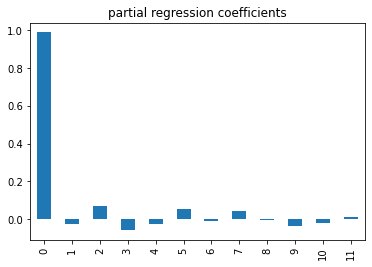

In [14]:
# Predict and measure R2
model = LinearRegression()
model = model.fit(X2_train, y2_train)

print('R2: ', r2_score(y2_test, model.predict(X2_test)))
pd.Series(model.coef_).plot(kind='bar')
plt.title('partial regression coefficients');

Only the 12th coefficient convey some information to the model (a Linear Regression based on these 12 autoregressive features)

Except for the 12th coefficient, most of the prediction is done by the intercept (basically predicting the mean of the last 12 values)

All the other features are statistically insignificant (high p-values)

## Decomposition

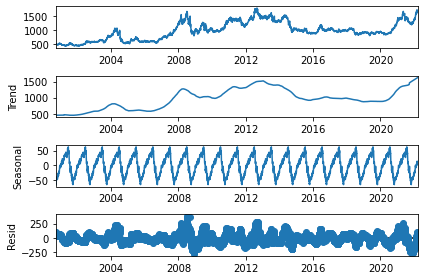

In [15]:
# Additive Decomposition (y = Trend + Seasonal + Residuals)
result_add = seasonal_decompose(df, model='additive', period = 253, extrapolate_trend='freq')
result_add.plot();

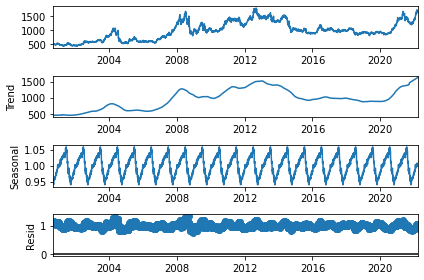

In [16]:
# Multiplicative Decomposition (y = Trend * Seasonal * Residuals)
result_mul = seasonal_decompose(df, model='multiplicative', period = 253, extrapolate_trend='freq')

result_mul.plot();

In [17]:
print(df.head(1))
print(result_add.trend[0] + result_add.seasonal[0] + result_add.resid[0])
print(result_mul.trend[0] * result_mul.seasonal[0] * result_mul.resid[0])

            soybean
Date               
2000-09-15   493.75
493.75
493.75000000000006


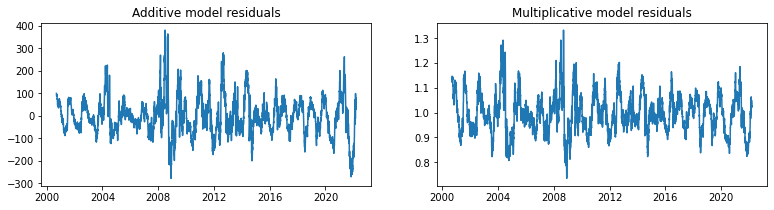

In [18]:
# Plot the residuals with "result_add.resid" to decide
f, (ax1, ax2) = plt.subplots(1,2, figsize=(13,3))
ax1.plot(result_add.resid); ax1.set_title("Additive model residuals")
ax2.plot(result_mul.resid); ax2.set_title("Multiplicative model residuals");

☝️ Additive and Multiplicative residuals seem to have| "stationarity"

## Testing the stationarity of our series

Augmented Dickey Fuller - ADF Tests


ADF tests the following null hypothesis:

H0 : The series is not-stationary.

A p-value close to 0 (e.g. p < 0.05) indicates stationarity.

In [19]:
from statsmodels.tsa.stattools import adfuller

adfuller(df['soybean'])[1]  # p-value

0.4231322492660957

In [20]:
# Sem nenhuma diferenciacao a serie nao eh estacionario, p-value > 0.05

In [21]:
print('additive resid: ', adfuller(result_add.resid.dropna())[1])
print('multipl resid: ', adfuller(result_mul.resid.dropna())[1])

additive resid:  1.0424066275793342e-10
multipl resid:  7.377903959037468e-12


☝️ p-values of the residuals are below 0.05, therefore we cannot discard the possibilities of our H0

Storing the results into the DataFrame for the multiplicative results:

In [22]:
df['trend'] = result_mul.trend
df['season'] = result_mul.seasonal
df['resid'] = result_mul.resid
df.head()

,soybean,trend,season,resid
Date,,,,
2000-09-15,493.75,456.306155,0.944510,1.145629
2000-09-18,484.00,456.335518,0.942045,1.125873
2000-09-19,484.25,456.364881,0.940315,1.128454
2000-09-20,483.25,456.394244,0.944393,1.121189
2000-09-21,486.50,456.423606,0.945408,1.127445


## Autocorrelation (ACF) and Partial Autocorrelation (AR / PACF)

### Autocorrelation - Direct and Indirect impact of previous values against the present one

The autocorrelation statistic measures how much does a value that is $n$ moments (hours, days, months, years, etc.) impacts the present value, both directly and indirectly.
<img width="700" src='attachment:image.png'>

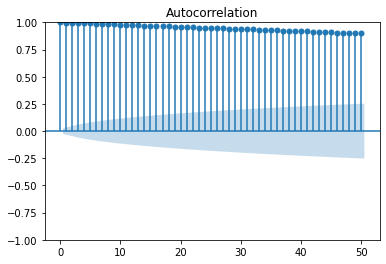

In [23]:
from statsmodels.graphics.tsaplots import plot_acf

# let's see the acf for every value from 1 up to 50 "lags" before the actual one
plot_acf(df['soybean'], lags=50)
plt.show()

### Partial Autocorrelation - Direct impact only

/Users/vanessalieberg/.pyenv/versions/3.8.12/envs/project_commodity_prices/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


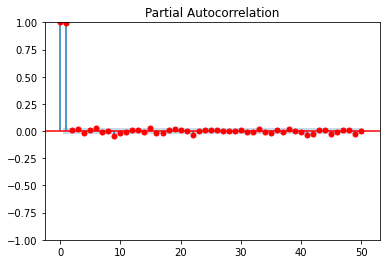

In [24]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(df['soybean'], lags=50, c='r')
plt.show()

The values shown in the graph above are the same as the ACF ones: they are correlations. However, AR removes the indirect correlation that past values might have between each other. So now, we can see that the **month before the actual** has a great correlation, but looking at two months before won't give us as much information. Looking 12 months behind, as expected, will also give us a high correlation by itself because of the seasonality

## ARIMA - Auto Regressive Integrated Moving Average

To recap things, so far we've seen how:
- a value in a Time Series can be caculated by a combination of trend, seasonality and residuals
- we need to difference our data in order to make it stationary (and we can diff it as many times as needed)
- Auto Regression (AR) shows how much does values prior to the actual one **directly** impact it
- Moving Averages (MA) shows how far is the actual value to an average of some values prior to it

By combining these informations, clever people got to an interesting model called ARIMA. In it, we need to decide three parameters:
- The amount of months prior the actual one to auto regress (which we'll call $p$) 🤔 12 months
- The amount of times we'll diff our values to make them stationary (which we'll call $i$) 🤔 We need to test it accordingly
- The amount of months to get the average and test against the actual one (which we'll call $q$) 🤔 lets give it a test too

### Differencing

In [25]:
# diffed_one = df.diff()
# diffed_one = diffed_one.dropna(inplace=True)
# diffed_one

<AxesSubplot:xlabel='Date'>

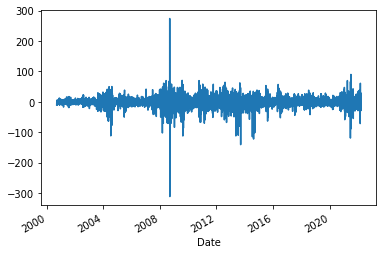

In [26]:
diffed_values = df['soybean'].diff()
diffed_values.dropna(inplace=True)
diffed_values.plot()

In [27]:
adfuller(diffed_values)[1]

1.2722740013544284e-27

/Users/vanessalieberg/.pyenv/versions/3.8.12/envs/project_commodity_prices/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


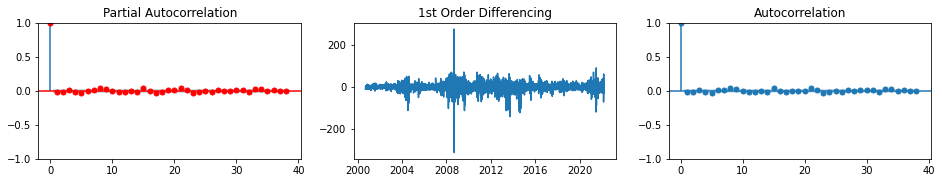

In [28]:
# ACF / PACF analysis of y_diff linearized
fig, axes = plt.subplots(1,3, figsize=(16,2.5))
plot_pacf(diffed_values, ax=axes[0], c='r');
axes[1].plot(diffed_values); axes[1].set_title('1st Order Differencing')
plot_acf(diffed_values, ax=axes[2]);

- With PACF, you'll be able to find $p$ by looking at how many dots you have **before the first one reaches the confidence area**
- With 1st Order Differencing, you'll be able to check if your data is stationary. If not, diff it again (**but not too much**)
- With ACF, you'll be able to find $q$ by looking at how many dots you have **before the first one reaches the confidence area**

In our case, $p = 1, i = 1, q = 1$

In [29]:
#pip freeze

In [31]:
#from statsmodels.tsa.arima_model import ARIMA #statsmodels 0.11
from statsmodels.tsa.arima.model import ARIMA #statsmodels 0.12

arima = ARIMA(df['soybean'], order=(1,1,1))
arima = arima.fit()
arima.summary()

/Users/vanessalieberg/.pyenv/versions/3.8.12/envs/project_commodity_prices/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/vanessalieberg/.pyenv/versions/3.8.12/envs/project_commodity_prices/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/vanessalieberg/.pyenv/versions/3.8.12/envs/project_commodity_prices/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                soybean   No. Observations:                 5411
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -23101.069
Date:                Fri, 18 Mar 2022   AIC                          46208.139
Time:                        19:00:37   BIC                          46227.927
Sample:                             0   HQIC                         46215.047
                               - 5411                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5576      0.214      2.603      0.009       0.138       0.977
ma.L1         -0.5782      0.214     -2.697      0.007      -0.998      -0.158
sigma2       299.5603      1.639    182.817      0.000     296.349     302.772
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):            276486.65
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               1.51   Skew:                            -1.07
Prob(H) (two-sided):                  0.00   Kurtosis:                        37.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Interpretar o resultado:

> Equacao da soja = 0.5576price_soy - 0.5782price_soy

> Intercept = const >>> nao eh estatisticamente significante, Pz eh 0.334 (> 0.05)
> Coef de AR e MA, sao significante, Pz igual a 0.023 e 0.017

> Cada dia que passa o valor da soja aumenta (AR coef > 0), para cada valor da soja, o aumento eh de 0.558 
Em contrapartida, o valor da moving average (coef <0), impacta ao contrario, reduz o valor para -0.5789

In [34]:
arima.forecast()

/Users/vanessalieberg/.pyenv/versions/3.8.12/envs/project_commodity_prices/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


5411    1666.256253
dtype: float64

/Users/vanessalieberg/.pyenv/versions/3.8.12/envs/project_commodity_prices/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


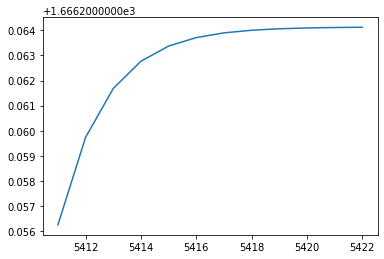

In [32]:
plt.plot(arima.forecast(steps = 12));

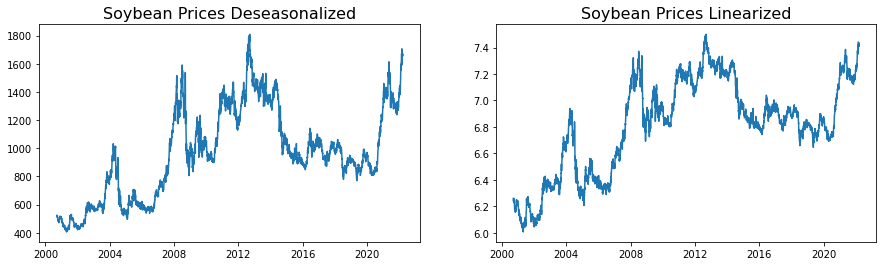

In [35]:
# Let's remove seasons
df['deseasonalized'] = df['soybean'].values/result_mul.seasonal

plt.figure(figsize=(15,4)); plt.subplot(1,2,1); plt.plot(df.deseasonalized);
plt.title('Soybean Prices Deseasonalized', fontsize=16);

# Also remove exponential trend 
df['linearized'] = np.log(df['deseasonalized'])

plt.subplot(1,2,2); plt.plot(df['linearized'])
plt.title('Soybean Prices Linearized', fontsize=16);

Text(0.5, 1.0, '2nd Order Differencing')

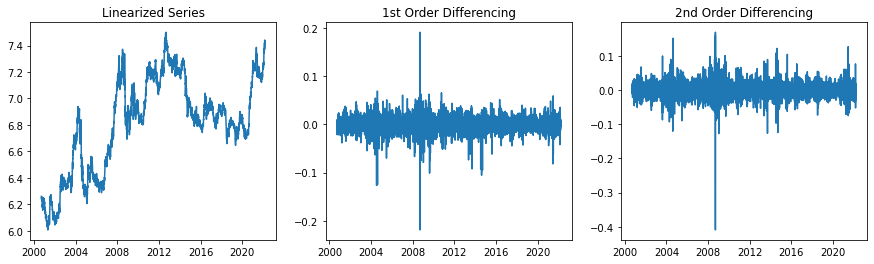

In [36]:
# Let's difference this and look at the ACFs
fig, axes = plt.subplots(1, 3,figsize=(15,4))

axes[0].plot(df['linearized']); axes[0].set_title('Linearized Series')
# 1st Differencing
y_diff = df['linearized'].diff().dropna()
axes[1].plot(y_diff); axes[1].set_title('1st Order Differencing')

# 2nd Differencing
y_diff_diff = df['linearized'].diff().diff().dropna()
axes[2].plot(y_diff_diff); axes[2].set_title('2nd Order Differencing')

In [37]:
# check with ADF Test for stationarity
print('p-value zero-diff: ', adfuller(df['linearized'])[1])
print('p-value first-diff: ', adfuller(df['linearized'].diff().dropna())[1])
print('p-value second-diff: ', adfuller(df['linearized'].diff().diff().dropna())[1])

p-value zero-diff:  0.4771296464896862
p-value first-diff:  0.0
p-value second-diff:  0.0


☝️ We should select  d=1

👉 Another way to try to find the differential:

In [ ]:
#!pip install pmdarima

In [38]:
# automatically estimate differencing term
from pmdarima.arima.utils import ndiffs
ndiffs(df['linearized'])

1

/Users/vanessalieberg/.pyenv/versions/3.8.12/envs/project_commodity_prices/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


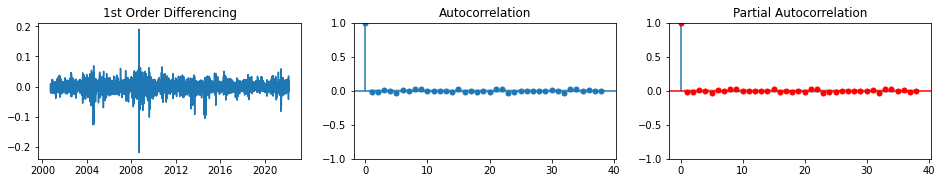

In [39]:
# ACF / PACF analysis of y_diff linearized
fig, axes = plt.subplots(1,3, figsize=(16,2.5))
axes[0].plot(y_diff); axes[0].set_title('1st Order Differencing')
plot_acf(y_diff, ax=axes[1]);
plot_pacf(y_diff, ax=axes[2], c='r');

A
R
I
M
A
(
p
=
1
,
d
=
1
,
q
=
1
)
☝️ We should select  d=1, i = 1, p = 1

In [40]:
arima = ARIMA(df['linearized'], order=(1,1,1))
arima = arima.fit()
arima.summary()

/Users/vanessalieberg/.pyenv/versions/3.8.12/envs/project_commodity_prices/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/vanessalieberg/.pyenv/versions/3.8.12/envs/project_commodity_prices/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/vanessalieberg/.pyenv/versions/3.8.12/envs/project_commodity_prices/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             linearized   No. Observations:                 5411
Model:                 ARIMA(1, 1, 1)   Log Likelihood               14756.437
Date:                Fri, 18 Mar 2022   AIC                         -29506.873
Time:                        19:04:04   BIC                         -29487.085
Sample:                             0   HQIC                        -29499.966
                               - 5411                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0947      0.533      0.178      0.859      -0.949       1.139
ma.L1         -0.1128      0.532     -0.212      0.832      -1.156       0.931
sigma2         0.0003   1.84e-06    135.823      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             47765.41
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.61   Skew:                            -0.81
Prob(H) (two-sided):                  0.00   Kurtosis:                        17.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [41]:
import pmdarima as pm
smodel = pm.auto_arima(df['linearized'],
                       start_p=1, max_p=2,
                       start_q=1, max_q=2,
                       seasonal=False,
                       trace=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-29505.921, Time=0.58 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-29507.897, Time=0.29 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-29507.688, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-29507.729, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-29508.909, Time=0.13 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.398 seconds


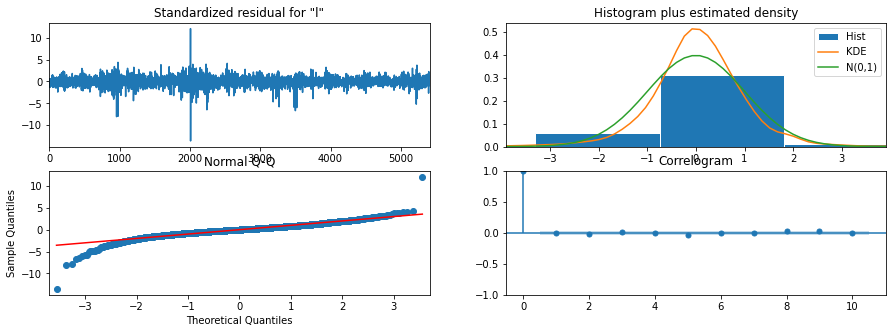

In [42]:
arima.plot_diagnostics();
fig = plt.gcf();
fig.set_size_inches(15, 5);

In [117]:
# Create a correct Training/Test split to predict the last 50 points
# Lets test the latest 30% of the sample... total sample size of 5411, lets set until 3780

train = df['linearized'][0:3780]
test = df['linearized'][3780:]

# Build Model
arima = ARIMA(train, order=(1, 1, 1))  
arima = arima.fit()



/Users/vanessalieberg/.pyenv/versions/3.8.12/envs/project_commodity_prices/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/vanessalieberg/.pyenv/versions/3.8.12/envs/project_commodity_prices/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/vanessalieberg/.pyenv/versions/3.8.12/envs/project_commodity_prices/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [118]:
# df['linearized'][0:3780].shape

(3780,)

In [119]:
# df['linearized'][3780:]

Date
2015-09-24    6.810292
2015-09-25    6.822077
2015-09-28    6.823410
2015-09-29    6.830819
2015-09-30    6.838542
                ...   
2022-03-14    7.427228
2022-03-15    7.414693
2022-03-16    7.410139
2022-03-17    7.420275
2022-03-18    7.415833
Name: linearized, Length: 1631, dtype: float64

In [120]:
forecast = arima.forecast(len(test))
forecast

/Users/vanessalieberg/.pyenv/versions/3.8.12/envs/project_commodity_prices/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


3780    6.802199
3781    6.802228
3782    6.802224
3783    6.802225
3784    6.802225
          ...   
5406    6.802225
5407    6.802225
5408    6.802225
5409    6.802225
5410    6.802225
Name: predicted_mean, Length: 1631, dtype: float64

In [121]:
arima.params

ar.L1    -0.153607
ma.L1     0.135631
sigma2    0.000295
dtype: float64

In [122]:
arima.conf_int()

,0,1
ar.L1,-1.46482,1.157606
ma.L1,-1.17587,1.447133
sigma2,0.00029,0.000301


In [123]:
graf_error = arima.forecasts_error[0]

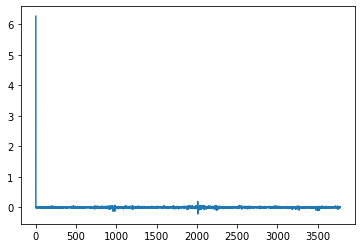

In [124]:
plt.plot(graf_error)

In [125]:
arima.forecast()

/Users/vanessalieberg/.pyenv/versions/3.8.12/envs/project_commodity_prices/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


3780    6.802199
dtype: float64

In [126]:
arima.conf_int().to_numpy()[:,0]

array([-1.46482022e+00, -1.17586998e+00,  2.90150359e-04])

In [128]:
test.shape

(1631,)

In [129]:
train.shape

(3780,)

In [136]:
result_mul.seasonal[-1631:].to_numpy()

array([0.9568576 , 0.96879846, 0.95390771, ..., 0.99793948, 0.99940514,
       1.00250071])

In [137]:
np.exp(forecast).to_numpy()

array([899.8240081 , 899.85029561, 899.84625761, ..., 899.84679529,
       899.84679529, 899.84679529])

In [163]:
forecast_full = (forecast).to_numpy()*result_mul.seasonal[-1631:].to_numpy()*result_mul.trend[-1631:].to_numpy()

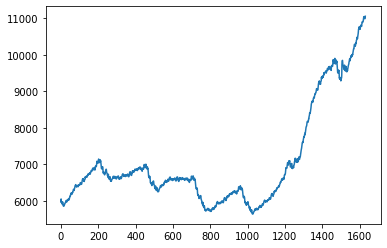

In [164]:
plt.plot(forecast_full)

In [165]:
np.exp(test).to_numpy()

array([ 907.13602595,  917.88957156,  919.11407424, ..., 1652.65533506,
       1669.49310972, 1662.09359108])

In [166]:
test_full = (test).to_numpy()*result_mul.seasonal[-1631:].to_numpy()*result_mul.trend[-1631:].to_numpy()

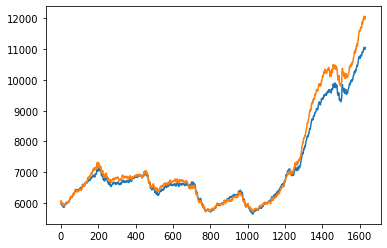

In [167]:
plt.plot(forecast_full)
plt.plot(test_full)

In [168]:
model_eval = (forecast_full - test_full)

In [169]:
MSE = (model_eval**2).mean()
MSE

87540.0658000624

In [170]:
RMSE = MSE**0.5

In [171]:
RMSE

295.8717049669711

In [172]:
result_mul.trend[-1631:].to_numpy()

array([ 919.40810277,  919.17687747,  918.94664032, ..., 1618.56073868,
       1619.88019909, 1621.19965949])